# Part 3: Network exploration with NetworkX

##  3.1: Importing network-structured data sets

NetworkX can read variuos formats for representing graphs and network, among them `.gml`, `.GraphML`, `.GEFX`, `.json` and `.yaml`. Additionaly, it can also read simple text files encoding adjacency lists and edge lists.

We've included a dataset representing the social circles of 10 individuals on Facebook. The network is given as an edge list in a simple text format, and saved as `facebook_combined.txt`.

The dataset is part of SNAP - the Stanford Network Analysis Project - which can be found here: https://snap.stanford.edu/index.html .
The dataset we'll be using can be found here: https://snap.stanford.edu/data/egonets-Facebook.html

Let's take a look at five random lines of this file:

In [1]:
FB_FNAME = 'facebook_combined.txt'
with open(FB_FNAME, 'r') as dataset:
    from random import shuffle
    lines = [line for line in dataset]
    shuffle(lines)
    for line in lines[:5]:
        print(line)

1385 1545

1688 1861

3186 3350

2218 2348

1282 1786



As you can see, each line contains two strings seperated by a whitespace, represting a single edge between the two nodes of the given names.

---
 
**Note**: A third argument can be given in each line, representing the weight of the edge. If missing, all edges are assumed of have an equal weight, resulting in an unwighted graph.

The above edge list can be imported into a NetworkX Graph object using the `read_edgelist()` function:

In [2]:
import networkx as nx
g = nx.read_edgelist('facebook_combined.txt')

Some basic stats of a graph object can be examined using the `nx.info()` function.

In [3]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


The next step is to have a look at the network. 

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

## 3.2: Visualizing networks

As you can see from the graph's information, it is much larger from the toy graph we used in the previous part. It is thus harder to visualize in a meaningful way.

There are several types of algorithms that draw network in a nice-looking way; among them, force-directed graph drawing is one of the most common approaches. Typically, edges are assigned with spring-like attractive forces, while simultaneously repulsive forces (like those of electrically charged particles) are used to separate all pairs of nodes.

Once the forces on the nodes and edges of a graph have been defined, the behavior of the entire graph under these sources may then be simulated as if it were a physical system. 

*(see more here: https://en.wikipedia.org/wiki/Force-directed_graph_drawing)*.

NetworkX supports the Fruchterman-Reingold force-directed algorithm with the  `spring_layout()` method.

In [118]:
# Position nodes using the Fruchterman-Reingold force-directed algorithm.
spr_layout = nx.spring_layout(g, iterations=40)

**Note:** Calling the `draw()` or `draw_networkx()` functions without giving the a position dictionary will result in these method running the spring layout positionning algorithm on their own. Running it yourself and saving the result to a variable which can be reused will save you a lot of time, as it is often the most expensive operation you'll use.

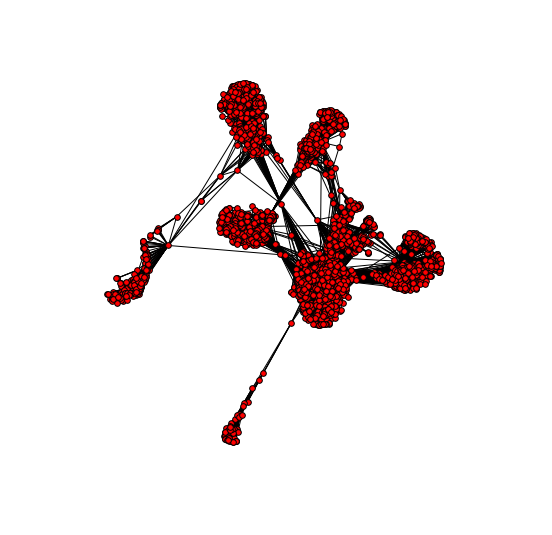

In [127]:
plt.figure(figsize=(9,9)) #sets width and height, respectively, in inches
plt.axis("off") # will display the network without axis
# Draw the graph with Matplotlib with options for node positions, labeling, titles, etc...
nx.draw_networkx(g, pos=spr_layout, with_labels=False, node_size=32)

## 3.3: Node Degree

A basic characteristic of nodes in a network is their degree. This is doubly true in a social network. The NetworkX function `degree()` returns a dict mapping each node to it's degree. Alternatively, you can use `g.degree()` where `g` is your graph object.

In [ ]:
degrees = g.degree() # dictionary node:degree

We can now draw them in a histogram very easily.

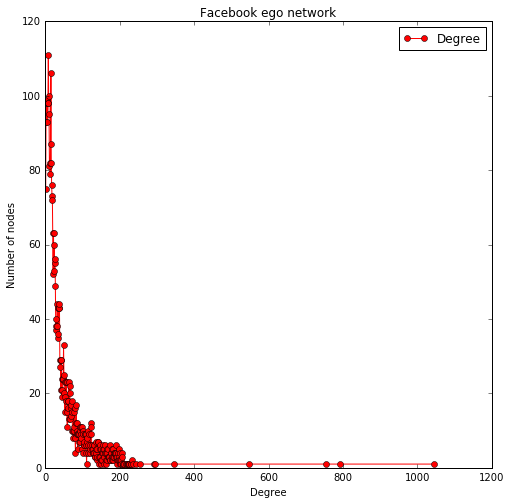

In [59]:
deg_values = sorted(set(degrees.values()))
deg_hist = [list(degrees.values()).count(x) for x in deg_values]
plt.figure(figsize=(8,8))
plt.plot(deg_values, deg_hist, 'ro-') # degree
plt.legend(['Degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Facebook ego network')

This kind of distribution is called a heavy tail distribution, and is charateristics of many real world networks, and especially of degrees in a social network. Since, as you can see, there is an exponential decrease in the number of nodes as the degree grows, these sorts of distributions are often better visualized in log form.

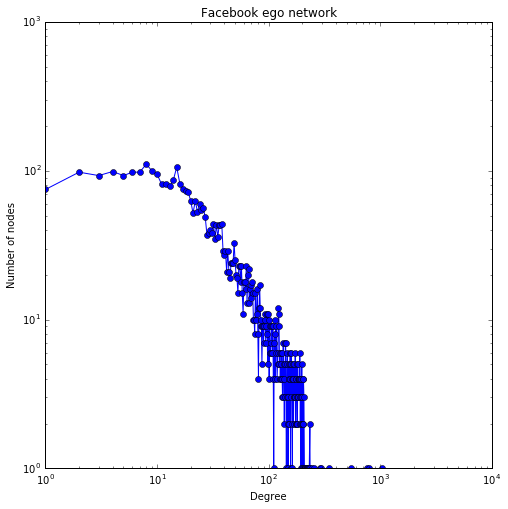

In [68]:
# degree_sequence=sorted(nx.degree(g).values(),reverse=True)
plt.figure(figsize=(8,8))
plt.loglog(deg_values, deg_hist,'b-',marker='o')
# plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Facebook ego network")
plt.ylabel("Number of nodes")
plt.xlabel("Degree")

Another way to get a grip on the distribution of a node attribute, especiaaly relative to the network's structure, is to draw the network while the setting to color intensity of nodes in correlation to that attribute's value.

In [124]:
import math
def color_nodes_by_attribute(g, node_pos, node_to_attribute_map, log=True):
    values = [node_to_attribute_map.get(node) for node in g.nodes()]
    if log:
        reg = abs(min(values))+1
        values = [math.log(value+reg) for value in values]
    plt.figure(figsize=(10,10))
    plt.axis("off")
    nx.draw_networkx(g, pos=node_pos, node_color=values, cmap=plt.get_cmap("Reds"), node_size=50, with_labels=False)

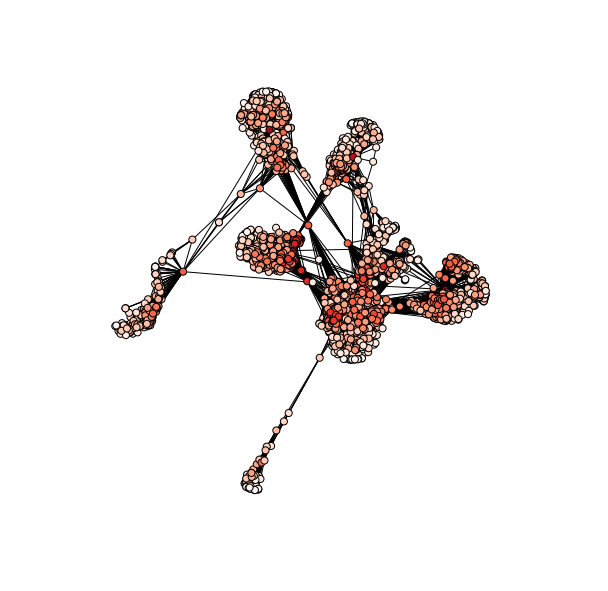

In [125]:
color_nodes_by_attribute(g, spr_layout, degrees)

## 3.4: Betweenness centrality

Betweenness centrality is an indicator of a node's centrality in a network. It is equal to the number of shortest paths from all vertices to all others that pass through that node. 

A node with high betweenness centrality has a large influence on the transfer of items/information through the network, under the assumption that item/information transfer follows the shortest paths.

The NetworkX `betweenness_centrality()` computes the betweenness centrality of each node in the graph.

In [87]:
#use normalized=False to get an unnormalized measure
centrality = nx.betweenness_centrality(g, k=500) # k is the number of nodes used to estimate the centrality

Let's draw a histogram of betweenness centrality distributions. Since this is the second time we want to write this kind of code, it's time to put it into a function.

In [79]:
def node_attribute_hist(values, attribute_name, log=False):
    uniq_values = sorted(set(values))
    val_counts = [values.count(x) for x in uniq_values]
    plt.figure(figsize=(8,8))
    if log:
        plt.loglog(uniq_values, val_counts,'b-',marker='o')
    else:
        plt.plot(uniq_values, val_counts, 'ro-') # degree
    plt.legend([attribute_name])
    plt.xlabel(attribute_name)
    plt.ylabel('Number of nodes')
    plt.title('Facebook ego network')

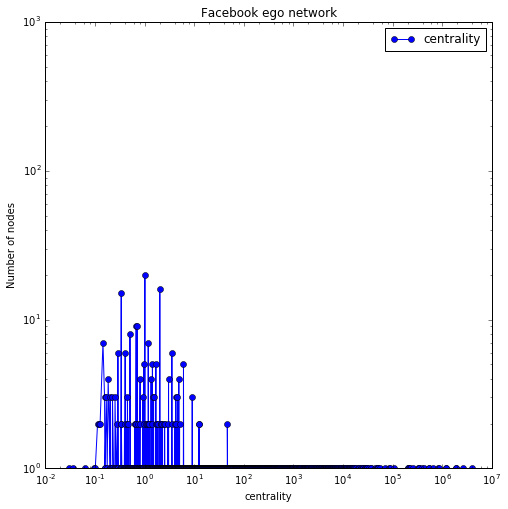

In [89]:
node_attribute_hist(list(centrality.values()), 'centrality', True)

And again, it's nice to visualize the attribute values on the graph itself:

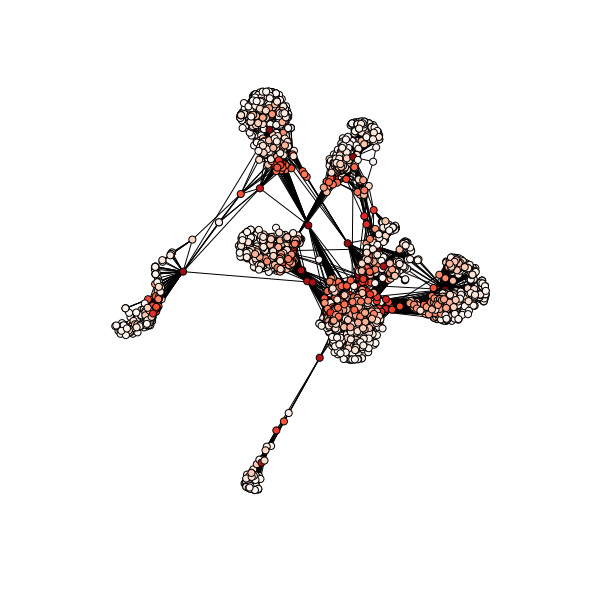

In [128]:
color_nodes_by_attribute(g, spr_layout, centrality)

## 3.5: PageRank

PageRank is a measure of nodes importance defined on directed networks only. Let's import a second dataset, this time of a directed network.

Wikipedia is a free encyclopedia written collaboratively by volunteers around the world. A small part of Wikipedia contributors are administrators, who are users with access to additional technical features that aid in maintenance. In order for a user to become an administrator a Request for adminship (RfA) is issued and the Wikipedia community via a public discussion or a vote decides who to promote to adminship.

The following dataset contains all the Wikipedia voting data from the inception of Wikipedia till January 2008. Nodes in the network represent wikipedia users and a directed edge from node i to node j represents that user i voted on user j.

In [159]:
wikig = nx.read_adjlist("wiki-Vote.txt", create_using=nx.DiGraph())
print(nx.info(wikig))

Name: 
Type: DiGraph
Number of nodes: 7115
Number of edges: 103689
Average in degree:  14.5733
Average out degree:  14.5733


In [171]:
pr = nx.pagerank(wikig)

In [165]:
max(pr.values())

0.004612715891167532

Plotting a histogram shows that PageRank is also, very often, heavy-tailed ditributed:

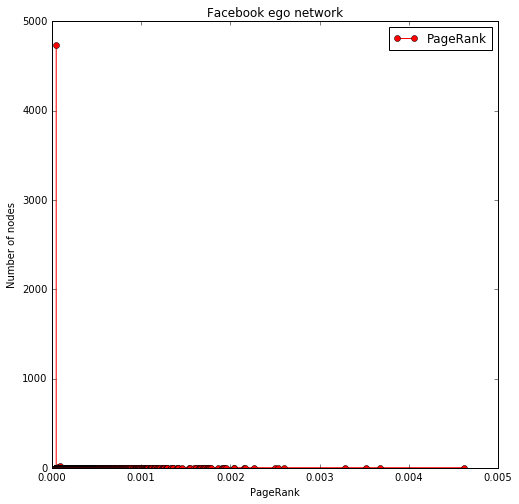

In [172]:
node_attribute_hist(list(pr.values()), 'PageRank', False)

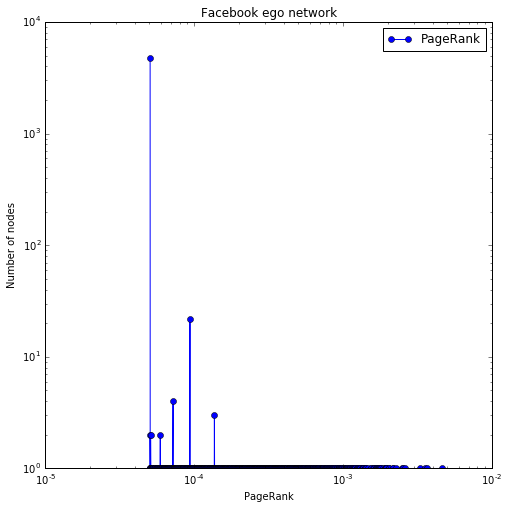

In [164]:
node_attribute_hist(list(pr.values()), 'PageRank', True)

## 3.6: Network-wise measures

### Clustering coefficient

In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterised by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes.

In [140]:
nx.average_clustering(g)

0.6055467186200865

The clustering coefficient value always lies between 0 and 1, when a measure of 1 indicates an `n`-clique (where `n` is the number of nodes in the network) and 0 a network of `n` disconnected nodes. As you can see, the Facebook sub-network is highly clustered.

### Node connectivity

Node connectivity is equal to the minimum number of nodes that must be removed to disconnect G or render it trivial. By Menger’s theorem, this is equal to the number of node independent paths (paths that share no nodes other than source and target).

In [142]:
# nx.node_connectivity(g) # don't run this - it will take very long on this network

It can be a very interesting when considering problem of network reselience to attack; e.g. communication network,

In [147]:
nx.clique.make_max_clique_graph(g)

KeyboardInterrupt: 

## 2.5: Community detection

The community package implement the [Louvain Community Detection Algorithm](https://en.wikipedia.org/wiki/Louvain_Modularity). The repository of this package can be found here: https://bitbucket.org/taynaud/python-louvain

In [11]:
import community

In [120]:
# run the algorithm, dividing the network into communities
# returns a mapping of each node to the community (an integer) it belongs to
node_to_community_map = community.best_partition(g)
# an array - corresponding to the graph's nodes - of the community numbers, will be used to indicate their colos
colors = [node_to_community_map.get(node) for node in g.nodes()]

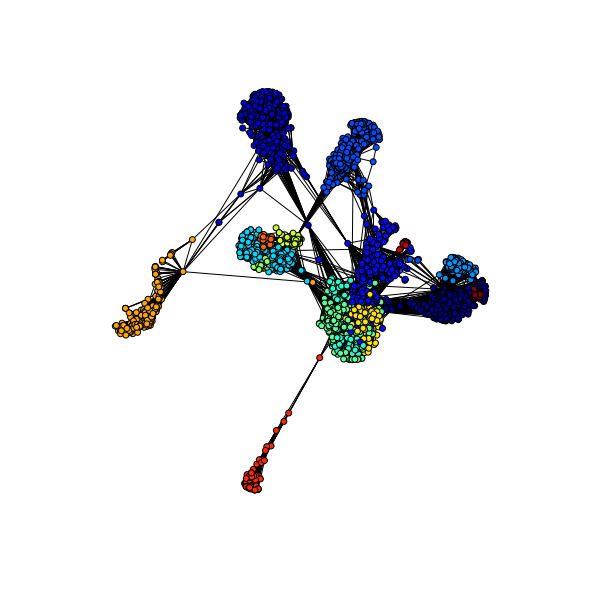

In [129]:
plt.figure(figsize=(10,10))
plt.axis("off")
nx.draw_networkx(g, pos=spr_layout, node_color=colors, node_size=35, with_labels=False)

Visualizing the community structure inferred by the Louvain Community Detection Algorithm shows that while force-directed graph drawing can separate some communities correctly, it can accidently bunch up together two or more distinct communities.